In [1]:
%pylab inline

PROFILE = None #'threads-2'

Populating the interactive namespace from numpy and matplotlib


In [2]:
matplotlib.rc('font', size=16)

In [3]:
from collections import OrderedDict
def generate_result(auc_b_c, auc_b_light, auc_c_light, log_loss_value, label=""):
    result = OrderedDict()
    result['name'] = [label]
    result['logloss'] = [log_loss_value]
    result['b vs c'] = [auc_b_c]
    result['b vs light'] = [auc_b_light]
    result['c vs light'] = [auc_c_light]
    return pandas.DataFrame(result)

In [4]:
import root_numpy
import pandas
from rep.data import LabeledDataStorage
from hep_ml.decisiontrain import DecisionTrainClassifier, DecisionTrainRegressor
from hep_ml.losses import LogLossFunction, MSELossFunction
from rep.metaml import FoldingClassifier, FoldingRegressor
from rep.report import ClassificationReport
from rep.report.metrics import RocAuc
from sklearn.metrics import roc_auc_score
from rep.estimators import SklearnClassifier

## Read data

In [5]:
treename = 'tag'
numpy.random.seed(11)

data_b = pandas.DataFrame(root_numpy.root2array('datasets/type=5.root', treename=treename)).dropna()
data_b = data_b.ix[numpy.random.choice(numpy.arange(len(data_b)), replace=False, size=40000), :]

data_c = pandas.DataFrame(root_numpy.root2array('datasets/type=4.root', treename=treename)).dropna()
data_light = pandas.DataFrame(root_numpy.root2array('datasets/type=0.root', treename=treename)).dropna()

In [6]:
set(data_light.JetParton)

{-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0}

### Add features

In [7]:
def add_features(*arrays):
    new_data = []
    for data in arrays:
        data['log_SVFDChi2'] = numpy.log1p(data['SVFDChi2'].values)
        data['log_SVMC'] = numpy.log1p(data['SVMC'].values)
        data['log_SVM'] = numpy.log1p(data['SVM'].values)
        data['log_SVSumIPChi2'] = numpy.log1p(data['SVSumIPChi2'].values)
        data['SV_M_PT'] = numpy.log1p(data['SVM'] / data['SVPT'])
        data['SV_MC_PT'] = numpy.log1p(data['SVMC'] / data['SVPT'])
        data['SVM_diff'] = numpy.log1p(data['SVMC'] ** 2 - data['SVM']**2)
        data['SV_Mdiff_PT'] = numpy.log1p(data['SVM_diff'] / data['SVPT'])
        data['SV_theta'] = numpy.log1p((data['SVMC'] ** 2 - data['SVM']**2) / data['SVPT'])
        data['SVM_rel'] = numpy.log1p(data['SVM'] / data['SVMC'])
        data['SV_R_FD_rel'] = numpy.log1p(data['SVR'] / data['SVFDChi2'])
        data['SV_Q_N_rel'] = 1. * data['SVQ'] / data['SVN']
        
        data = data.drop(['SVFDChi2', 'SVSumIPChi2', 'SVMC', 'SVM'], axis=1)
        new_data.append(data)
    return new_data

In [8]:
data_b, data_c, data_light = add_features(data_b, data_c, data_light)

In [9]:
len(data_b), len(data_c), len(data_light)

(40000, 19941, 42423)

In [10]:
jet_features = [column for column in data_b.columns if "Jet" in column]
sv_features = [column for column in data_b.columns if "SV" in column]

In [11]:
print "Jet features", ", ".join(jet_features)
print "SV features", ", ".join(sv_features)

Jet features JetParton, JetFlavor, JetPx, JetPy, JetPz, JetE, JetQ, JetSigma1, JetSigma2, JetMult, JetPTHard, JetPTD, JetNDis
SV features SVR, SVPT, SVDR, SVN, SVQ, log_SVFDChi2, log_SVMC, log_SVM, log_SVSumIPChi2, SV_M_PT, SV_MC_PT, SVM_diff, SV_Mdiff_PT, SV_theta, SVM_rel, SV_R_FD_rel, SV_Q_N_rel


In [12]:
jet_features_base = ['JetQ', 'JetSigma1', 'JetSigma2', 'JetMult', 'JetPTHard', 'JetPTD', 'JetNDis']

## Feature pdfs

/moosefs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


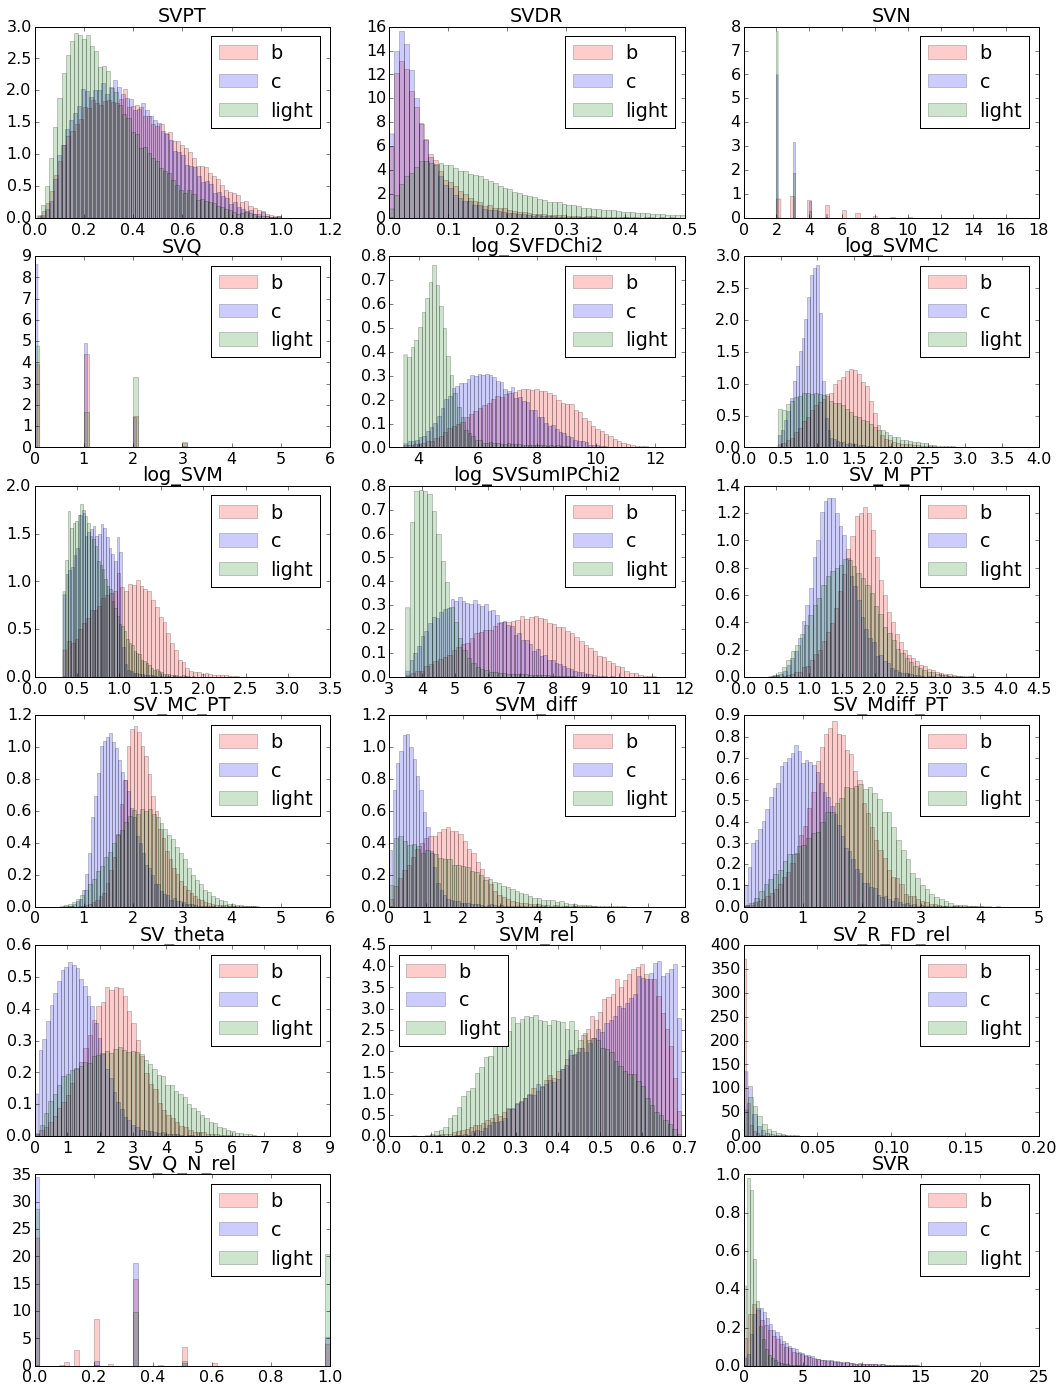

In [13]:
figsize(18, 24)
for i, feature in enumerate(sv_features):
    subplot(len(sv_features) / 3 + 1, 3, i)
    hist(data_b[feature].values, label='b', alpha=0.2, bins=60, normed=True)
    hist(data_c[feature].values, label='c', alpha=0.2, bins=60, normed=True)
    hist(data_light[feature].values, label='light', alpha=0.2, bins=60, normed=True)
    title(feature); legend(loc='best'); 

# Prepare datasets:
* b vs c
* b vs light
* c vs light
* b, c vs light

In [14]:
labels = numpy.array([0] * len(data_b) + [1] * len(data_c) + [2] * len(data_light))
full_data = pandas.concat([data_b, data_c, data_light])
full_data.index = range(len(full_data))

In [15]:
data_b_c_lds = LabeledDataStorage(pandas.concat([data_b, data_c]), [1] * len(data_b) + [0] * len(data_c))
data_c_light_lds = LabeledDataStorage(pandas.concat([data_c, data_light]), [1] * len(data_c) + [0] * len(data_light))
data_b_light_lds = LabeledDataStorage(pandas.concat([data_b, data_light]), [1] * len(data_b) + [0] * len(data_light))

data_bc_light_lds = LabeledDataStorage(full_data, [1] * len(data_b) + [1] * len(data_c) + [0] * len(data_light))

# Baseline

* b vs c
* b, c vs light

In [16]:
baseline_features = ['log_SVM', 'log_SVMC', 'SVR', 'SVPT', 'SVDR', 'SVN', 'SVQ', 'log_SVFDChi2', 'log_SVSumIPChi2']

## b vs c

In [17]:
tt_base = DecisionTrainClassifier(learning_rate=0.1, n_estimators=2000, depth=6, pretransform_needed=True, 
                                  max_features=6, loss=LogLossFunction(regularization=30))
tt_folding_base_b_c = FoldingClassifier(SklearnClassifier(tt_base), n_folds=2, 
                                        random_state=11, parallel_profile='threads-2', 
                                        features=baseline_features)
%time tt_folding_base_b_c.fit_lds(data_b_c_lds)
pass

CPU times: user 40.5 s, sys: 2.44 s, total: 43 s
Wall time: 10.9 s


In [18]:
report_base_b_c = tt_folding_base_b_c.test_on_lds(data_b_c_lds)

KFold prediction using folds column


KFold prediction using folds column


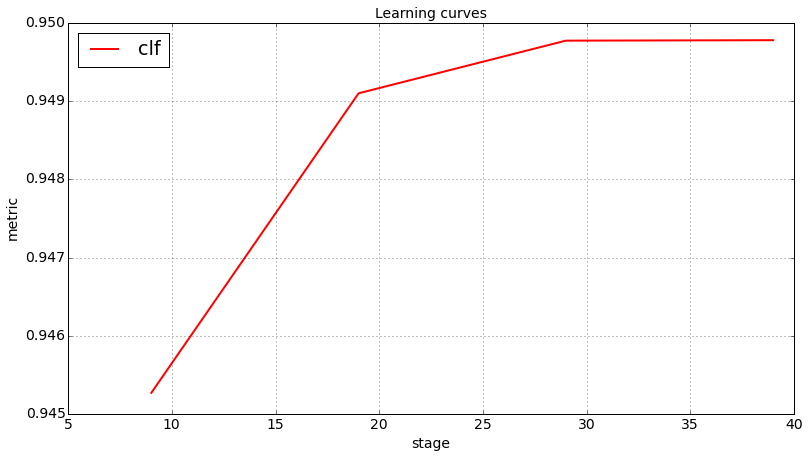

In [19]:
report_base_b_c.learning_curve(RocAuc()).plot(new_plot=True)

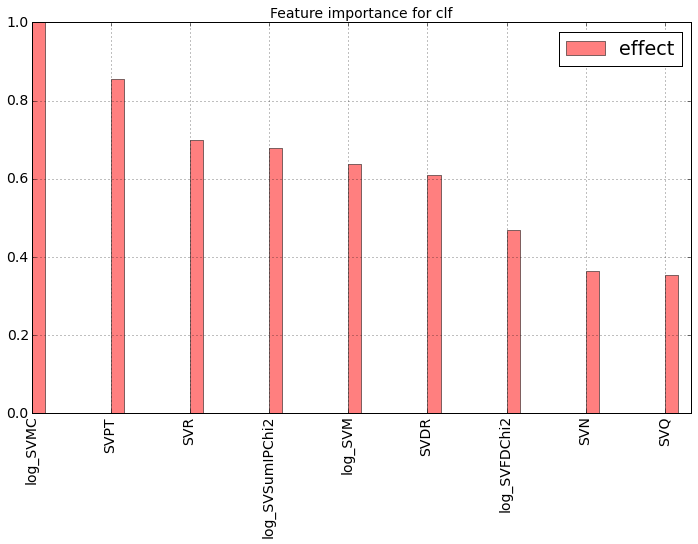

In [20]:
report_base_b_c.feature_importance()

In [21]:
auc_base_b_c = report_base_b_c.compute_metric(RocAuc())['clf']
auc_base_b_c

0.9497825152951207

## b, c vs light

In [22]:
tt_base = DecisionTrainClassifier(learning_rate=0.1, n_estimators=15000, depth=6, pretransform_needed=True, 
                                  max_features=6, loss=LogLossFunction(regularization=30))
tt_folding_base_bc_light = FoldingClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=11,
                                             parallel_profile='threads-2', features=baseline_features)
%time tt_folding_base_bc_light.fit_lds(data_bc_light_lds)

CPU times: user 6min 31s, sys: 24.1 s, total: 6min 56s
Wall time: 2min 5s


FoldingClassifier(base_estimator=SklearnClassifier(clf=DecisionTrainClassifier(bootstrap=True, depth=6, learning_rate=0.1,
            loss=LogLossFunction(regularization=30), max_features=6,
            n_estimators=15000, n_threads=4, pretransform_needed=True,
            train_features=None, use_friedman_mse=True),
         features=None),
         features=['log_SVM', 'log_SVMC', 'SVR', 'SVPT', 'SVDR', 'SVN', 'SVQ', 'log_SVFDChi2', 'log_SVSumIPChi2'],
         n_folds=2, parallel_profile='threads-2', random_state=11)

In [23]:
report_base_bc_light = tt_folding_base_bc_light.test_on_lds(data_bc_light_lds)

KFold prediction using folds column


KFold prediction using folds column


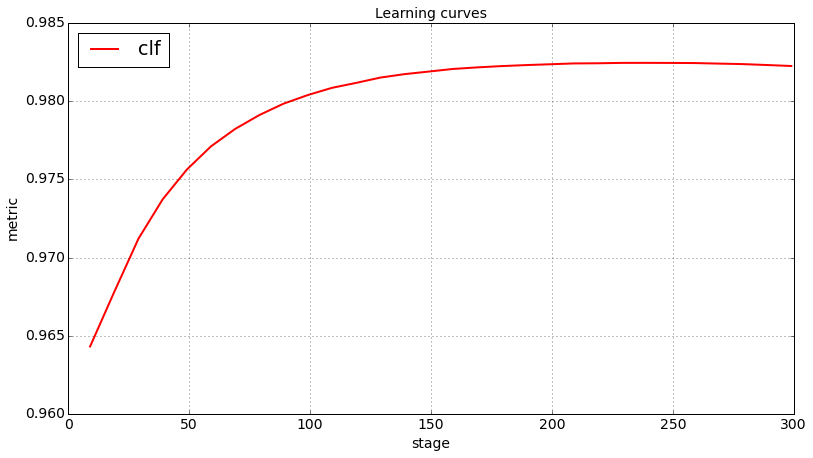

In [24]:
report_base_bc_light.learning_curve(RocAuc()).plot(new_plot=True)

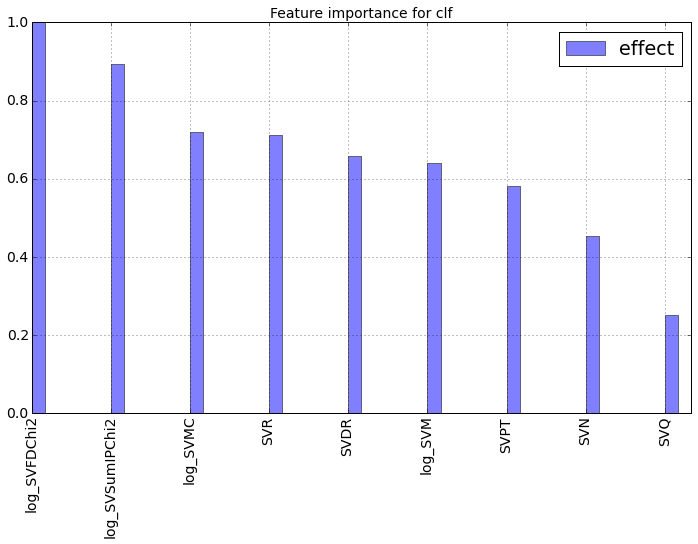

In [25]:
report_base_bc_light.feature_importance()

In [26]:
print report_base_bc_light.compute_metric(RocAuc())
probs_base_bc_light = tt_folding_base_bc_light.predict_proba(full_data)[:, 1]
baseline_result = generate_result(auc_base_b_c, 
                                  roc_auc_score(labels < 1, probs_base_bc_light, sample_weight=(labels != 1) * 1),
                                  roc_auc_score(labels < 2, probs_base_bc_light, sample_weight=(labels != 0) * 1),
                                  -1,
                                  label='baseline')

OrderedDict([('clf', 0.98226038450259434)])
KFold prediction using folds column


## baseline results

In [27]:
baseline_result

,name,logloss,b vs c,b vs light,c vs light
0,baseline,-1,0.949783,0.985596,0.975569


# One versus One

### b vs c

In [28]:
tt_base = DecisionTrainClassifier(learning_rate=0.1, n_estimators=2000, depth=6, pretransform_needed=True, 
                                  max_features=6, loss=LogLossFunction(regularization=30))
tt_folding_b_c = FoldingClassifier(SklearnClassifier(tt_base), n_folds=2, 
                                   random_state=11, parallel_profile='threads-2', 
                                   features=sv_features)
%time tt_folding_b_c.fit_lds(data_b_c_lds)
pass

CPU times: user 19.7 s, sys: 2.53 s, total: 22.3 s
Wall time: 10.7 s


KFold prediction using folds column
KFold prediction using folds column


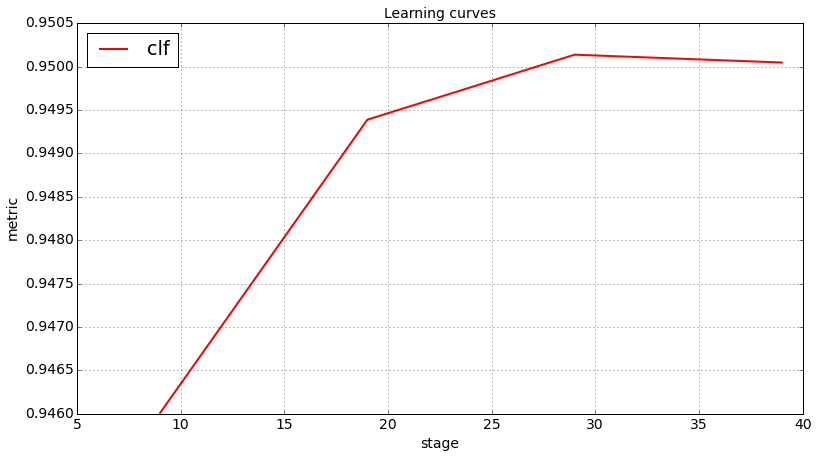

In [29]:
report_b_c = tt_folding_b_c.test_on_lds(data_b_c_lds)
report_b_c.learning_curve(RocAuc()).plot(new_plot=True)

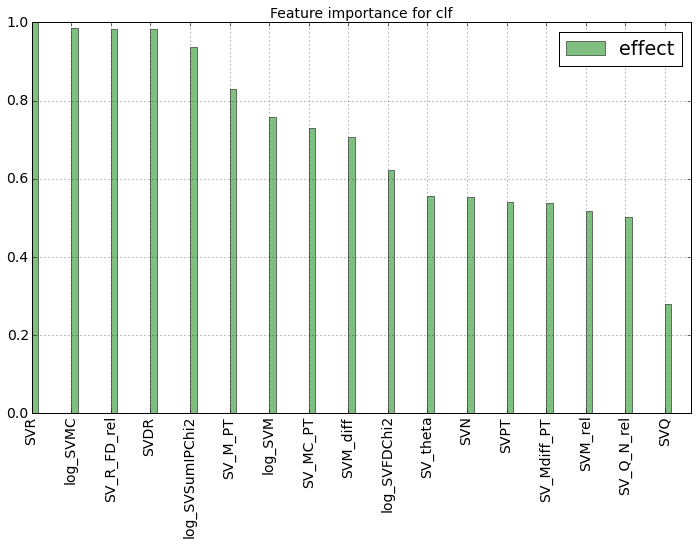

In [30]:
report_b_c.feature_importance()

In [31]:
report_b_c.compute_metric(RocAuc())['clf']

0.95004684193370448

### c vs light

In [32]:
tt_base = DecisionTrainClassifier(learning_rate=0.1, n_estimators=7000, depth=6, pretransform_needed=True, 
                                  max_features=6, loss=LogLossFunction(regularization=30))
tt_folding_c_light = FoldingClassifier(SklearnClassifier(tt_base), n_folds=2, 
                                       random_state=11, parallel_profile='threads-2', 
                                       features=sv_features)
%time tt_folding_c_light.fit_lds(data_c_light_lds)
pass

CPU times: user 1min 11s, sys: 7.2 s, total: 1min 18s
Wall time: 37.8 s


KFold prediction using folds column
KFold prediction using folds column


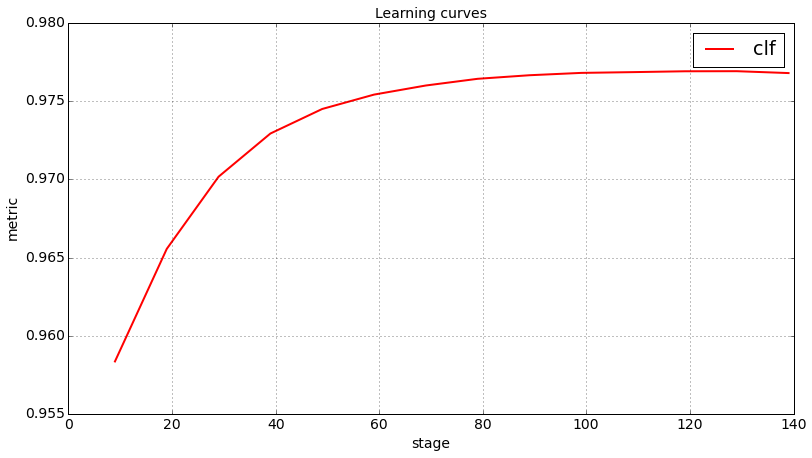

In [33]:
report_c_light = tt_folding_c_light.test_on_lds(data_c_light_lds)
report_c_light.learning_curve(RocAuc()).plot(new_plot=True)

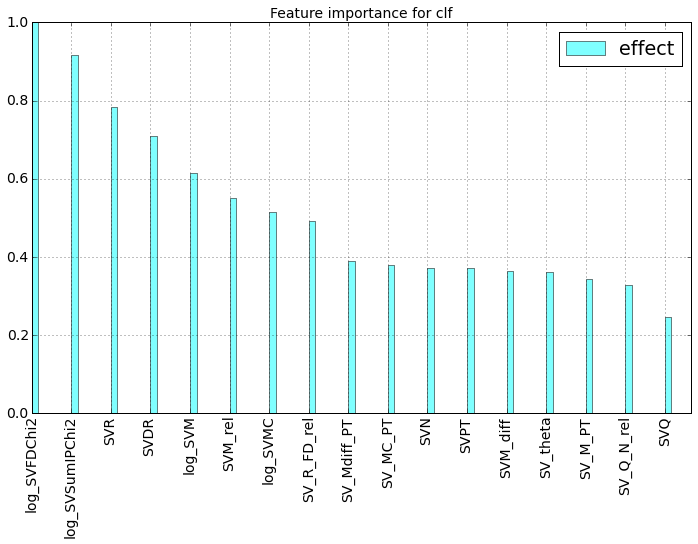

In [34]:
report_c_light.feature_importance()

In [35]:
report_c_light.compute_metric(RocAuc())['clf']

0.97680800324041994

### b vs light

In [36]:
tt_base = DecisionTrainClassifier(learning_rate=0.1, n_estimators=10000, depth=6, pretransform_needed=True, 
                                  max_features=6, loss=LogLossFunction(regularization=30))
tt_folding_b_light = FoldingClassifier(SklearnClassifier(tt_base), n_folds=2, 
                                       random_state=11, parallel_profile='threads-2', 
                                       features=sv_features)
%time tt_folding_b_light.fit_lds(data_b_light_lds)
pass

CPU times: user 2min 10s, sys: 17.8 s, total: 2min 28s
Wall time: 1min 11s


KFold prediction using folds column
KFold prediction using folds column


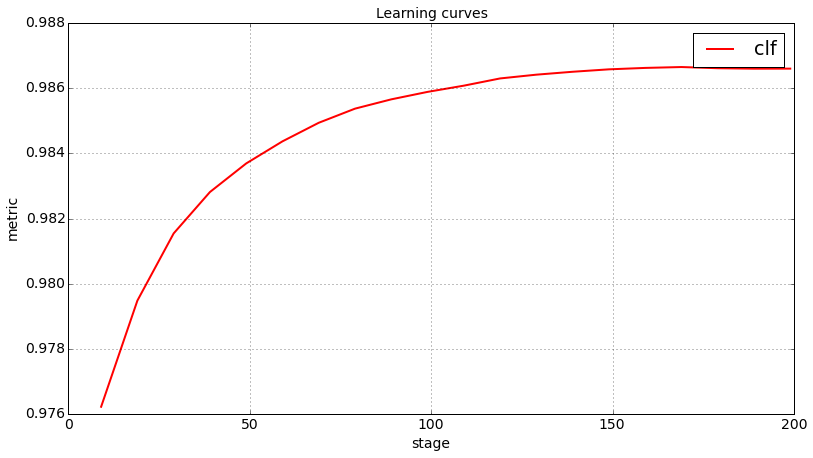

In [37]:
report_b_light = tt_folding_b_light.test_on_lds(data_b_light_lds)
report_b_light.learning_curve(RocAuc()).plot(new_plot=True)

In [38]:
report_b_light.compute_metric(RocAuc())['clf']

0.98660432283195421

### One vs One result

In [39]:
probs_b_c = numpy.concatenate([tt_folding_b_c.predict_proba(pandas.concat([data_b, data_c])),
                               tt_folding_b_c.predict_proba(data_light)])[:, 1]
probs_c_light = numpy.concatenate([tt_folding_c_light.predict_proba(data_b), 
                                   tt_folding_c_light.predict_proba(pandas.concat([data_c, data_light]))])[:, 1]
probs_b_light = tt_folding_b_light.predict_proba(pandas.concat([data_b, data_light]))[:, 1]
probs_b_light = numpy.concatenate([probs_b_light[:len(data_b)], tt_folding_b_light.predict_proba(data_c)[:, 1], 
                                   probs_b_light[len(data_b):]])

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)


In [40]:
one_vs_one_result = generate_result(report_b_c.compute_metric(RocAuc())['clf'],
                                    report_b_light.compute_metric(RocAuc())['clf'],
                                    report_c_light.compute_metric(RocAuc())['clf'],
                                    -1, label='one vs one, add features')

# Baseline with new features

In [41]:
tt_base = DecisionTrainClassifier(learning_rate=0.1, n_estimators=15000, depth=6, pretransform_needed=True, 
                                  max_features=6, loss=LogLossFunction(regularization=30))
tt_folding_base_add_bc_light = FoldingClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=11,
                                                 parallel_profile='threads-2', features=sv_features)
%time tt_folding_base_add_bc_light.fit_lds(data_bc_light_lds)

CPU times: user 3min 56s, sys: 24.7 s, total: 4min 21s
Wall time: 2min 4s


FoldingClassifier(base_estimator=SklearnClassifier(clf=DecisionTrainClassifier(bootstrap=True, depth=6, learning_rate=0.1,
            loss=LogLossFunction(regularization=30), max_features=6,
            n_estimators=15000, n_threads=4, pretransform_needed=True,
            train_features=None, use_friedman_mse=True),
         features=None),
         features=['SVR', 'SVPT', 'SVDR', 'SVN', 'SVQ', 'log_SVFDChi2', 'log_SVMC', 'log_SVM', 'log_SVSumIPChi2', 'SV_M_PT', 'SV_MC_PT', 'SVM_diff', 'SV_Mdiff_PT', 'SV_theta', 'SVM_rel', 'SV_R_FD_rel', 'SV_Q_N_rel'],
         n_folds=2, parallel_profile='threads-2', random_state=11)

KFold prediction using folds column
KFold prediction using folds column


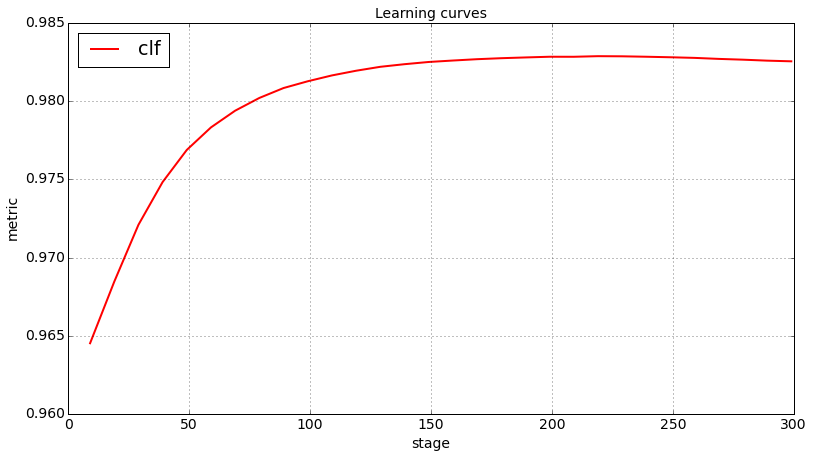

In [42]:
report_base_add_bc_light = tt_folding_base_add_bc_light.test_on_lds(data_bc_light_lds)
report_base_add_bc_light.learning_curve(RocAuc()).plot(new_plot=True)

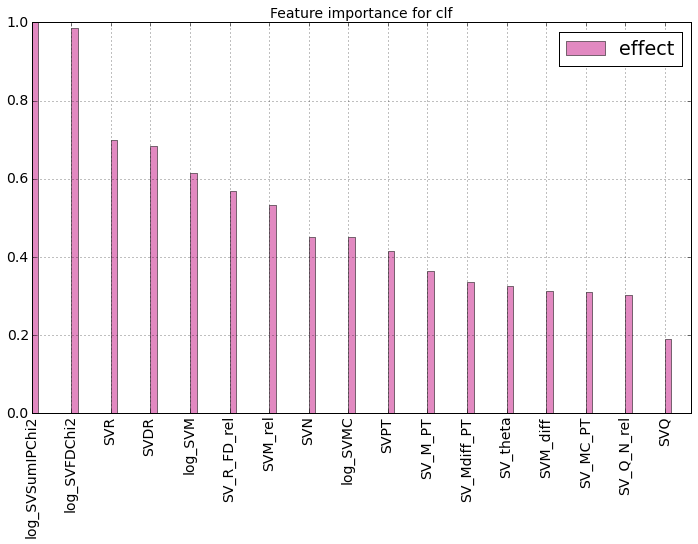

In [43]:
report_base_add_bc_light.feature_importance()

In [44]:
print report_base_add_bc_light.compute_metric(RocAuc())
probs_base_add_bc_light = tt_folding_base_add_bc_light.predict_proba(full_data)[:, 1]
baseline_add_result = generate_result(report_b_c.compute_metric(RocAuc())['clf'], 
                                      roc_auc_score(labels < 1, probs_base_add_bc_light, 
                                                    sample_weight=(labels != 1) * 1),
                                      roc_auc_score(labels < 2, probs_base_add_bc_light, 
                                                    sample_weight=(labels != 0) * 1),
                                      -1,
                                      label='baseline, add features')

OrderedDict([('clf', 0.98256034277312876)])
KFold prediction using folds column


In [45]:
pandas.concat([baseline_result, baseline_add_result, one_vs_one_result])

,name,logloss,b vs c,b vs light,c vs light
0,baseline,-1,0.949783,0.985596,0.975569
0,"baseline, add features",-1,0.950047,0.985900,0.975862
0,"one vs one, add features",-1,0.950047,0.986604,0.976808


# MN b vs c

In [46]:
from rep_ef.estimators import MatrixNetClassifier

In [47]:
mn_base = MatrixNetClassifier(connection_url='mn',
                              iterations=5000, regularization=0.02, sync=False)
mn_folding_b_c = FoldingClassifier(mn_base, n_folds=2, random_state=11,
                                   parallel_profile='threads-2', features=sv_features)
%time mn_folding_b_c.fit_lds(data_b_c_lds)

CPU times: user 1.02 s, sys: 332 ms, total: 1.35 s
Wall time: 1.97 s


FoldingClassifier(base_estimator=MatrixNetClassifier(auto_stop=None, baseline_feature=None,
          command_line_params=None, connection_token=None,
          connection_url='mn', dump_filename=None,
          features_sample_rate_per_iteration=1.0, intervals=64,
          iterations=5000, max_features_per_iteration=6,
          regularization=0.02, sync=False, train_features=None,
          training_fraction=0.5),
         features=['SVR', 'SVPT', 'SVDR', 'SVN', 'SVQ', 'log_SVFDChi2', 'log_SVMC', 'log_SVM', 'log_SVSumIPChi2', 'SV_M_PT', 'SV_MC_PT', 'SVM_diff', 'SV_Mdiff_PT', 'SV_theta', 'SVM_rel', 'SV_R_FD_rel', 'SV_Q_N_rel'],
         n_folds=2, parallel_profile='threads-2', random_state=11)

KFold prediction using folds column
KFold prediction using folds column


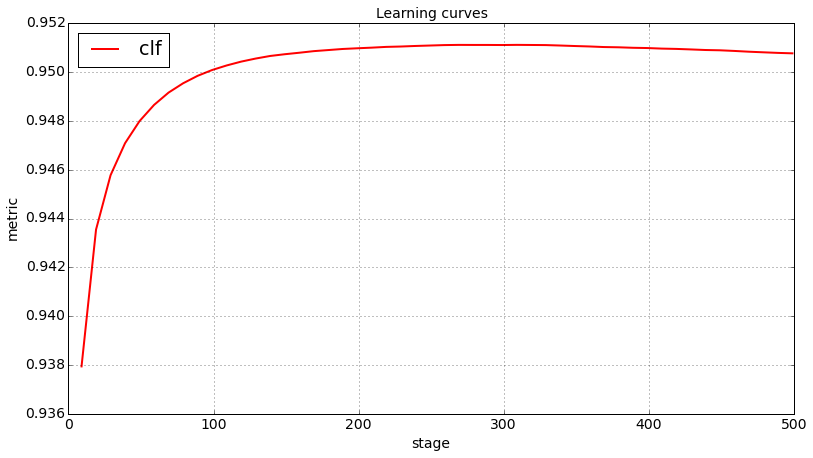

In [48]:
report_mn_b_c = mn_folding_b_c.test_on_lds(data_b_c_lds)
report_mn_b_c.learning_curve(RocAuc()).plot(new_plot=True)

In [49]:
report_mn_b_c.compute_metric(RocAuc())['clf']

0.95076077428413819

In [ ]:
mn_base = MatrixNetClassifier(connection_url='mn', 
                              iterations=5000, regularization=0.03, sync=False)
mn_folding_bc_light = FoldingClassifier(mn_base, n_folds=2, random_state=11,
                                        parallel_profile='threads-2', features=sv_features)
%time mn_folding_bc_light.fit_lds(data_bc_light_lds)

KFold prediction using folds column
KFold prediction using folds column


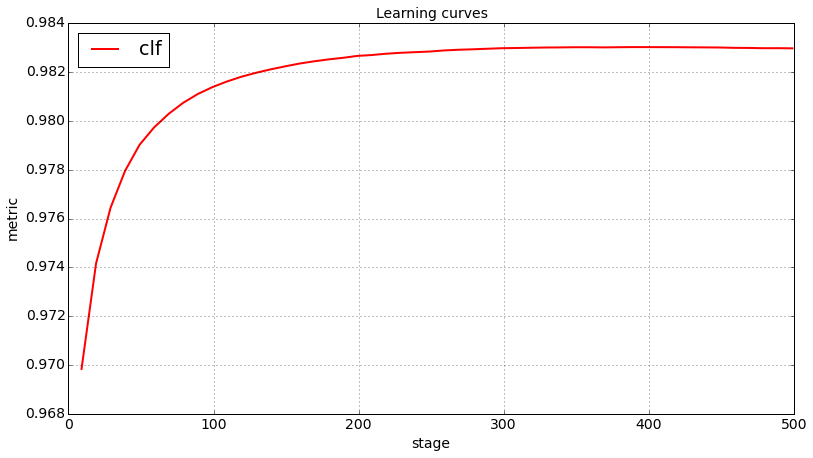

In [56]:
report_mn_bc_light = mn_folding_bc_light.test_on_lds(data_bc_light_lds)
report_mn_bc_light.learning_curve(RocAuc()).plot(new_plot=True)

In [57]:
report_mn_bc_light.compute_metric(RocAuc())['clf']

0.98296983622577772

In [58]:
probs_mn_bc_light = mn_folding_bc_light.predict_proba(full_data)[:, 1]
mn_result = generate_result(report_mn_b_c.compute_metric(RocAuc())['clf'], 
                            roc_auc_score(labels < 1, probs_mn_bc_light, 
                                          sample_weight=(labels != 1) * 1),
                            roc_auc_score(labels < 2, probs_mn_bc_light, 
                                            sample_weight=(labels != 0) * 1),
                            -1,
                            label='mn, add features')

KFold prediction using folds column


In [59]:
pandas.concat([baseline_result, baseline_add_result, one_vs_one_result, mn_result])

,name,logloss,b vs c,b vs light,c vs light
0,baseline,-1,0.949783,0.985596,0.975569
0,"baseline, add features",-1,0.950047,0.985900,0.975862
0,"one vs one, add features",-1,0.950047,0.986604,0.976808
0,"mn, add features",-1,0.950761,0.986284,0.976321


# Hierarchical training

In [60]:
from hep_ml.nnet import MLPClassifier
from rep.estimators import SklearnClassifier, TheanetsClassifier

In [61]:
from utils import train_one_vs_one

### mlp features (one vs one)

In [62]:
mlp_columns = train_one_vs_one([SklearnClassifier(MLPClassifier(layers=(30, 10), scaler='iron', 
                                                                epochs=700, random_state=11))]*3, 
                                data_b, data_c, data_light, 'mlp', folding=True,
                                n_folds=2, features=sv_features)

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)


In [63]:
full_data = pandas.concat([full_data, mlp_columns], axis=1)

In [65]:
mlp_features = list(mlp_columns.columns)

In [69]:
from sklearn.ensemble import AdaBoostClassifier
from hep_ml.nnet import MLPMultiClassifier

In [85]:
combo_base = AdaBoostClassifier(MLPMultiClassifier(layers=(40, 30, 20, 10), random_state=11, epochs=700), random_state=11,
                                n_estimators=10, learning_rate=0.1)
combo_multi = FoldingClassifier(SklearnClassifier(combo_base), n_folds=2, random_state=13,
                                features=sv_features)
%time combo_multi.fit(full_data, labels)

CPU times: user 1h 57min 18s, sys: 2h 34min 42s, total: 4h 32min 1s
Wall time: 45min 6s


FoldingClassifier(base_estimator=SklearnClassifier(clf=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=MLPMultiClassifier(epochs=700, layers=(40, 30, 20, 10), random_state=11,
          scaler='standard', trainer='irprop-', trainer_parameters=None),
          learning_rate=0.1, n_estimators=10, random_state=11),
         features=None),
         features=['SVR', 'SVPT', 'SVDR', 'SVN', 'SVQ', 'log_SVFDChi2', 'log_SVMC', 'log_SVM', 'log_SVSumIPChi2', 'SV_M_PT', 'SV_MC_PT', 'SVM_diff', 'SV_Mdiff_PT', 'SV_theta', 'SVM_rel', 'SV_R_FD_rel', 'SV_Q_N_rel'],
         n_folds=2, parallel_profile=None, random_state=13)

In [86]:
combo_multi_probs = combo_multi.predict_proba(full_data)
log_loss(labels, combo_multi_probs)
combo_multi_result = generate_result(1 - roc_auc_score(labels > 0, combo_multi_probs[:, 0] / combo_multi_probs[:, 1], 
                                                 sample_weight=(labels != 2) * 1),
                               1 - roc_auc_score(labels > 1, combo_multi_probs[:, 0] / combo_multi_probs[:, 2],
                                                      sample_weight=(labels != 1) * 1),
                               1 - roc_auc_score(labels > 1, combo_multi_probs[:, 1] / combo_multi_probs[:, 2],
                                                 sample_weight=(labels != 0) * 1),
                               log_loss(labels, combo_multi_probs),
                               label='multiclass combo')

pandas.concat([baseline_result, baseline_add_result, one_vs_one_result, 
               mn_result,  combo_multi_result])

KFold prediction using folds column


,name,logloss,b vs c,b vs light,c vs light
0,baseline,-1.000000,0.949783,0.985596,0.975569
0,"baseline, add features",-1.000000,0.950047,0.985900,0.975862
0,"one vs one, add features",-1.000000,0.950047,0.986604,0.976808
0,"mn, add features",-1.000000,0.950761,0.986284,0.976321
0,multiclass combo,0.323668,0.951336,0.989367,0.982157


KFold prediction using folds column


,name,logloss,b vs c,b vs light,c vs light
0,baseline,-1.000000,0.949783,0.985596,0.975569
0,"baseline, add features",-1.000000,0.950047,0.985900,0.975862
0,"one vs one, add features",-1.000000,0.950047,0.986604,0.976808
0,"mn, add features",-1.000000,0.950761,0.986284,0.976321
0,multiclass combo,0.329491,0.950639,0.988430,0.980871


In [64]:
sv_features

['SVR',
 'SVPT',
 'SVDR',
 'SVN',
 'SVQ',
 'log_SVFDChi2',
 'log_SVMC',
 'log_SVM',
 'log_SVSumIPChi2',
 'SV_M_PT',
 'SV_MC_PT',
 'SVM_diff',
 'SV_Mdiff_PT',
 'SV_theta',
 'SVM_rel',
 'SV_R_FD_rel',
 'SV_Q_N_rel']

In [ ]:
sv_features_without_categorial = list(set(sv_features) - {'SVN', 'SVQ', "SV_Q_N_rel"})

In [ ]:
mlp_columns_without_categorial = train_one_vs_one([SklearnClassifier(MLPClassifier(
                layers=(30, 10), epochs=700, scaler='iron', random_state=11))]*3, 
                data_b, data_c, data_light, 'rbf_cat', folding=True,
                n_folds=3, features=sv_features_without_categorial)

In [62]:
full_data = pandas.concat([full_data, mlp_columns_without_categorial], axis=1)

In [63]:
mlp_columns_group1 = train_one_vs_one([SklearnClassifier(MLPClassifier(
                                        layers=(20, 10), epochs=400, random_state=11))]*3, 
                                        data_b, data_c, data_light, 'gr1', folding=True,
                                        n_folds=3, features=['log_SVM', 'log_SVMC', 'SVR', 'log_SVFDChi2'])

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)


In [64]:
mlp_columns_group2 = train_one_vs_one([SklearnClassifier(MLPClassifier(
                                        layers=(20, 10), epochs=400, random_state=11))]*3, 
                                        data_b, data_c, data_light, 'gr2', folding=True,
                                        n_folds=3, features=['SVPT', 'SVDR', 'SVR', 'log_SVFDChi2'])

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)


In [65]:
full_data = pandas.concat([full_data, mlp_columns_group1], axis=1)
full_data = pandas.concat([full_data, mlp_columns_group2], axis=1)

### mn features (one vs one)

In [66]:
mn_columns = train_one_vs_one([MatrixNetClassifier(connection='mn', connection_auth='AUTH_HEADERS', 
                               iterations=5000, regularization=0.02, sync=False)]*3, 
                               data_b, data_c, data_light, 'mn', folding=True,
                               n_folds=2, features=sv_features)

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)


In [67]:
full_data = pandas.concat([full_data, mn_columns], axis=1)

In [68]:
mpl_features = list(mlp_columns.columns)
mn_features = list(mn_columns.columns)
rbf_features_cat = list(mlp_columns_without_categorial.columns)
mlp1_features = list(mlp_columns_group1.columns)
mlp2_features = list(mlp_columns_group2.columns)

# Random forest selection

In [69]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
rf_folding = FoldingClassifier(RandomForestClassifier(n_estimators=500, max_depth=8, min_samples_split=100,
                                                      min_samples_leaf=20, random_state=11),
                              n_folds=2, random_state=13,
                              features=sv_features)
rf_folding.fit_lds(data_b_c_lds)

FoldingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=20, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=11, verbose=0, warm_start=False),
         features=['SVR', 'SVPT', 'SVDR', 'SVN', 'SVQ', 'log_SVFDChi2', 'log_SVMC', 'log_SVM', 'log_SVSumIPChi2', 'SVM_diff', 'SV_theta', 'SVM_rel', 'SV_R_FD_rel', 'SV_Q_N_rel'],
         n_folds=2, parallel_profile=None, random_state=13)

In [71]:
p = rf_folding.predict_proba(pandas.concat([data_b, data_c]))[:, 1]

KFold prediction using folds column


In [72]:
p_b = p[:len(data_b)]
p_c = p[len(data_b):]

(0, 5)

/moosefs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


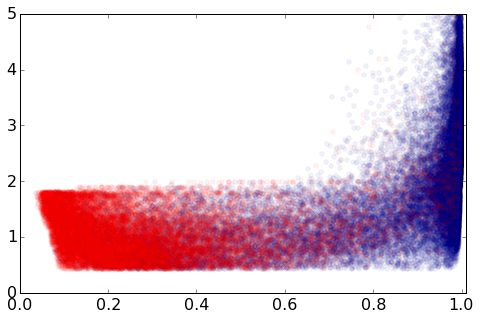

In [73]:
figure(figsize=(8, 5))
scatter(p_b, numpy.exp(data_b.log_SVM.values) + 0.01, alpha=0.05)
scatter(p_c, numpy.exp(data_c.log_SVM.values) + 0.01, alpha=0.05, color='r')
xlim(0, 1.01)
ylim(0, 5)

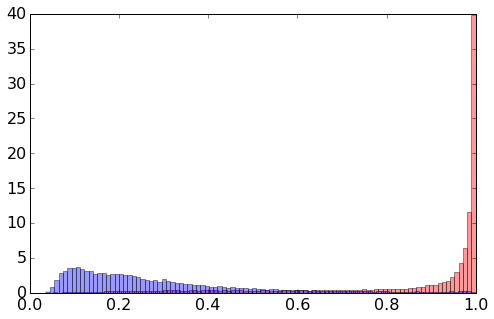

In [74]:
figure(figsize=(8, 5))
hist(p[:len(data_b)], bins=100, alpha=0.4, normed=True)
hist(p[len(data_b):], bins=100, alpha=0.4, normed=True)
pass

In [75]:
data_b_new = full_data[labels == 0].ix[p_b > 0.8, :]
data_c_new = full_data[labels == 1].ix[p_c < 0.8, :]

In [76]:
data_b_remain = full_data[labels == 0].ix[p_b < 0.8, :]
data_c_remain = full_data[labels == 1].ix[p_c > 0.8, :]

In [77]:
labels_new = numpy.array([0] * len(data_b_new) + [1] * len(data_c_new) + [2] * len(data_light))
full_data_new = pandas.concat([data_b_new, data_c_new, full_data[labels == 2]])
full_data_new.index = range(len(full_data_new))

In [78]:
data_multi_lds_new = LabeledDataStorage(full_data_new, labels_new)

In [79]:
from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=3000, colsample=0.7, eta=0.01, nthreads=16, 
                             subsample=0.7, max_depth=6)
multi_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=13,
                                  features=sv_features)
%time multi_folding.fit_lds(data_multi_lds_new)

CPU times: user 21min 22s, sys: 2min 27s, total: 23min 49s
Wall time: 7min 14s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=6, min_child_weight=1.0, missing=-999.0,
         n_estimators=3000, nthreads=16, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.7, verbose=0),
         features=['SVR', 'SVPT', 'SVDR', 'SVN', 'SVQ', 'log_SVFDChi2', 'log_SVMC', 'log_SVM', 'log_SVSumIPChi2', 'SVM_diff', 'SV_theta', 'SVM_rel', 'SV_R_FD_rel', 'SV_Q_N_rel'],
         n_folds=2, parallel_profile=None, random_state=13)

In [80]:
p1 = multi_folding.predict_proba(full_data_new)
p2 = multi_folding.predict_proba(data_b_remain)
p3 = multi_folding.predict_proba(data_c_remain)

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)


In [81]:
p = numpy.concatenate([p1, p2, p3])
labels_temp = numpy.array(list(labels_new) + [0] * len(p2) + [1] * len(p3))

In [73]:
from sklearn.metrics import log_loss

In [84]:
multi_result_selection = generate_result(1 - roc_auc_score(labels_temp > 0, p[:, 0] / p[:, 1], 
                                                           sample_weight=(labels_temp != 2) * 1),
                                           1 - roc_auc_score(labels_temp > 1, p[:, 0] / p[:, 2],
                                                             sample_weight=(labels_temp != 1) * 1),
                                           1 - roc_auc_score(labels_temp > 1, p[:, 1] / p[:, 2],
                                                             sample_weight=(labels_temp != 0) * 1),
                                       log_loss(labels_temp, p),
                                       label='multiclass, NN features + selection')

pandas.concat([baseline_result, baseline_add_result, one_vs_one_result, mn_result, multi_result_selection])

,name,logloss,b vs c,b vs light,c vs light
0,baseline,-1.000000,0.949783,0.985596,0.975569
0,"baseline, add features",-1.000000,0.950050,0.986048,0.976101
0,"one vs one, add features",-1.000000,0.950050,0.986691,0.977061
0,"mn, add features",-1.000000,0.950821,0.986283,0.976571
0,"multiclass, NN features + selection",0.793759,0.940595,0.960148,0.970705


# Multiclassification

In [105]:
data_multi_lds = LabeledDataStorage(full_data, labels)

In [106]:
from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=3000, colsample=0.7, eta=0.01, nthreads=16, 
                             subsample=0.7, max_depth=6)
multi_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=13,
                                  features=sv_features + mlp1_features + mlp2_features)
%time multi_folding.fit_lds(data_multi_lds)

CPU times: user 36min 22s, sys: 2min 45s, total: 39min 7s
Wall time: 9min 55s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=6, min_child_weight=1.0, missing=-999.0,
         n_estimators=3000, nthreads=16, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.7, verbose=0),
         features=['SVR', 'SVPT', 'SVDR', 'SVN', 'SVQ', 'log_SVFDChi2', 'log_SVMC', 'log_SVM', 'log_SVSumIPChi2', 'SVM_diff', 'SV_theta', 'SVM_rel', 'SV_R_FD_rel', 'SV_Q_N_rel', 'rbf_b_c', 'rbf_b_light', 'rbf_c_light', 'gr1_b_c', 'gr1_b_light', 'gr1_c_light', 'gr2_b_c', 'gr2_b_light', 'gr2_c_light'],
         n_folds=2, parallel_profile=None, random_state=13)

In [107]:
multi_report = multi_folding.test_on_lds(data_multi_lds)

KFold prediction using folds column


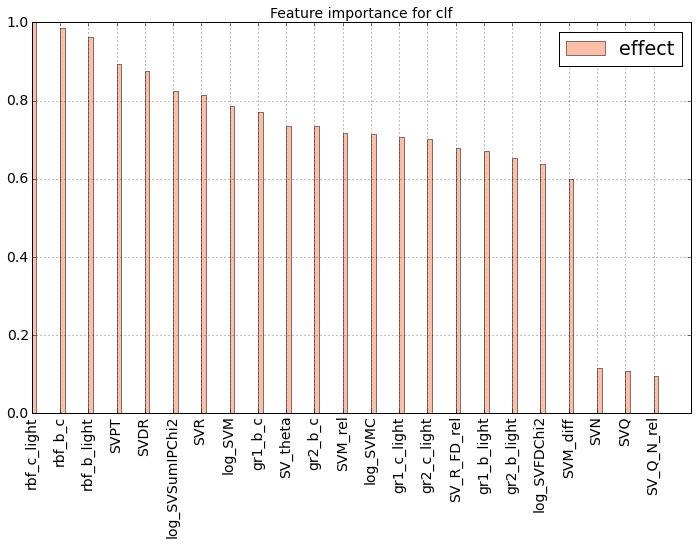

In [108]:
multi_report.feature_importance().plot(new_plot=True)

In [109]:
from sklearn.metrics import log_loss
probs_xgb_mult = multi_folding.predict_proba(full_data)
print 'log loss\t', log_loss(labels, probs_xgb_mult)

KFold prediction using folds column
log loss	0.302776518194


In [87]:
# 0.302275	0.949335	0.988883	0.981100

# my 0.949379 0.988952 0.981269

#0.949040	0.987689	0.979919

# 0.9501 0.9865 0.9777
#0.951279	0.987887	0.98012

In [110]:
multi_result = generate_result(1 - roc_auc_score(labels > 0, probs_xgb_mult[:, 0] / probs_xgb_mult[:, 1], 
                                                 sample_weight=(labels != 2) * 1),
                               1 - roc_auc_score(labels > 1, probs_xgb_mult[:, 0] / probs_xgb_mult[:, 2],
                                                      sample_weight=(labels != 1) * 1),
                               1 - roc_auc_score(labels > 1, probs_xgb_mult[:, 1] / probs_xgb_mult[:, 2],
                                                 sample_weight=(labels != 0) * 1),
                               log_loss(labels, probs_xgb_mult),
                               label='multiclass, NN features')

pandas.concat([baseline_result, baseline_add_result, one_vs_one_result, mn_result, multi_result])

,name,logloss,b vs c,b vs light,c vs light
0,baseline,-1.000000,0.949783,0.985596,0.975569
0,"baseline, add features",-1.000000,0.950050,0.986048,0.976101
0,"one vs one, add features",-1.000000,0.950050,0.986691,0.977061
0,"mn, add features",-1.000000,0.950821,0.986283,0.976571
0,"multiclass, NN features",0.302777,0.949580,0.988853,0.980874


## MLP

In [145]:
full_data['mult_xgb_0'] = probs_xgb_mult[:, 0] / probs_xgb_mult[:, 1]
full_data['mult_xgb_1'] = probs_xgb_mult[:, 0] / probs_xgb_mult[:, 2]
full_data['mult_xgb_2'] = probs_xgb_mult[:, 1] / probs_xgb_mult[:, 2]

In [146]:
xgb_features = ['mult_xgb_0', 'mult_xgb_1', 'mult_xgb_2']

In [154]:
full_data['mn'] = probs_mn_bc_light

In [163]:
from hep_ml.nnet import MLPMultiClassifier
mlp_multi_base = MLPMultiClassifier(layers=(30, 10), random_state=11, epochs=700)
mlp_multi = FoldingClassifier(mlp_multi_base, n_folds=2, 
                              features=sv_features + rbf_features + combo_features)
%time mlp_multi.fit(full_data, labels)

CPU times: user 4min 57s, sys: 6min 11s, total: 11min 9s
Wall time: 1min 23s


FoldingClassifier(base_estimator=MLPMultiClassifier(epochs=700, layers=(30, 10), random_state=11,
          scaler='standard', trainer='irprop-', trainer_parameters=None),
         features=['SVM', 'SVMC', 'SVR', 'SVPT', 'SVDR', 'SVN', 'SVQ', 'log_SVFDChi2', 'log_SVSumIPChi2', 'SVM_diff', 'SV_theta', 'SVM_rel', 'SV_R_FD_rel', 'SV_Q_N_rel', 'rbf_b_c', 'rbf_b_light', 'rbf_c_light', 'combo_0', 'combo_1', 'combo_2'],
         n_folds=2, parallel_profile=None, random_state=None)

In [164]:
mlp_multi_probs = mlp_multi.predict_proba(full_data)
log_loss(labels, mlp_multi_probs)

KFold prediction using folds column


0.30371548769389162

In [217]:
mlp_multi_result = generate_result(1 - roc_auc_score(labels > 0, mlp_multi_probs[:, 0] / mlp_multi_probs[:, 1], 
                                                 sample_weight=(labels != 2) * 1),
                               1 - roc_auc_score(labels > 1, mlp_multi_probs[:, 0] / mlp_multi_probs[:, 2],
                                                      sample_weight=(labels != 1) * 1),
                               1 - roc_auc_score(labels > 1, mlp_multi_probs[:, 1] / mlp_multi_probs[:, 2],
                                                 sample_weight=(labels != 0) * 1),
                               log_loss(labels, mlp_multi_probs),
                               label='multiclass NN, NN features')

pandas.concat([baseline_result, baseline_add_result, one_vs_one_result, mn_result, multi_result, mlp_multi_result])

,name,logloss,b vs c,b vs light,c vs light
0,baseline,-1.000000,0.949218,0.985552,0.975261
0,"baseline, add features",-1.000000,0.949592,0.985957,0.975653
0,"one vs one, add features",-1.000000,0.949592,0.986477,0.977006
0,"mn, add features",-1.000000,0.950182,0.986155,0.976294
0,"multiclass, NN features",0.300620,0.949504,0.989182,0.981199
0,"multiclass NN, NN features",0.303715,0.949605,0.988334,0.981056


## Bagging over NN

In [363]:
from hep_ml.nnet import MLPMultiClassifier
mlp_multi_base = MLPMultiClassifier(layers=(30, 10), random_state=11, epochs=700)
mlp_multi = FoldingClassifier(mlp_multi_base, n_folds=2, random_state=13,
                              features=sv_features + rbf_features + combo_features + jet_features)
%time mlp_multi.fit(full_data, labels)

CPU times: user 5min 1s, sys: 6min 10s, total: 11min 11s
Wall time: 1min 24s


FoldingClassifier(base_estimator=MLPMultiClassifier(epochs=700, layers=(30, 10), random_state=11,
          scaler='standard', trainer='irprop-', trainer_parameters=None),
         features=['SVM', 'SVMC', 'SVR', 'SVPT', 'SVDR', 'SVN', 'SVQ', 'log_SVFDChi2', 'log_SVSumIPChi2', 'SVM_diff', 'SV_theta', 'SVM_rel', 'SV_R_FD_rel', 'SV_Q_N_rel', 'rbf_b_c', 'rbf_b_light', 'rbf_c_light', 'combo_0', 'combo_1', 'combo_2'],
         n_folds=2, parallel_profile=None, random_state=13)

In [364]:
mlp_multi_probs = mlp_multi.predict_proba(full_data)
log_loss(labels, mlp_multi_probs)

KFold prediction using folds column


0.3035165177688911

In [365]:
mlp_multi_result2 = generate_result(1 - roc_auc_score(labels > 0, mlp_multi_probs[:, 0] / mlp_multi_probs[:, 1], 
                                                 sample_weight=(labels != 2) * 1),
                               1 - roc_auc_score(labels > 1, mlp_multi_probs[:, 0] / mlp_multi_probs[:, 2],
                                                      sample_weight=(labels != 1) * 1),
                               1 - roc_auc_score(labels > 1, mlp_multi_probs[:, 1] / mlp_multi_probs[:, 2],
                                                 sample_weight=(labels != 0) * 1),
                               log_loss(labels, mlp_multi_probs),
                               label='multiclass2 NN, NN features')

pandas.concat([baseline_result, baseline_add_result, one_vs_one_result, 
               mn_result, multi_result, mlp_multi_result, mlp_multi_result2])

,name,logloss,b vs c,b vs light,c vs light
0,baseline,-1.000000,0.949218,0.985552,0.975261
0,"baseline, add features",-1.000000,0.949592,0.985957,0.975653
0,"one vs one, add features",-1.000000,0.949592,0.986477,0.977006
0,"mn, add features",-1.000000,0.950182,0.986155,0.976294
0,"multiclass, NN features",0.300620,0.949504,0.989182,0.981199
0,"multiclass NN, NN features",0.303715,0.949605,0.988334,0.981056
0,"multiclass2 NN, NN features",0.303517,0.949405,0.988516,0.981045


In [352]:
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier

In [238]:
combo_base = BaggingClassifier(MLPMultiClassifier(layers=(30, 10), random_state=11, epochs=700), max_samples=0.8, 
                               max_features=0.8, bootstrap_features=True, random_state=11,
                               n_estimators=10)
combo_multi = FoldingClassifier(SklearnClassifier(combo_base), n_folds=2, random_state=13,
                                features=sv_features + rbf_features + jet_features_base)
%time combo_multi.fit(full_data, labels)

CPU times: user 49min 11s, sys: 1h 44s, total: 1h 49min 56s
Wall time: 13min 38s


FoldingClassifier(base_estimator=SklearnClassifier(clf=BaggingClassifier(base_estimator=MLPMultiClassifier(epochs=700, layers=(30, 10), random_state=11,
          scaler='standard', trainer='irprop-', trainer_parameters=None),
         bootstrap=True, bootstrap_features=True, max_features=0.8,
         max_samples=0.8, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=11, verbose=0, warm_start=False),
         features=None),
         features=['SVM', 'SVMC', 'SVR', 'SVPT', 'SVDR', 'SVN', 'SVQ', 'log_SVFDChi2', 'log_SVSumIPChi2', 'SVM_diff', 'SV_theta', 'SVM_rel', 'SV_R_FD_rel', 'SV_Q_N_rel', 'rbf_b_c', 'rbf_b_light', 'rbf_c_light', 'JetQ', 'JetSigma1', 'JetSigma2', 'JetMult', 'JetPTHard', 'JetPTD', 'JetNDis'],
         n_folds=2, parallel_profile=None, random_state=13)

In [307]:
combo_base = AdaBoostClassifier(MLPMultiClassifier(layers=(30, 10), random_state=11, epochs=700), random_state=11,
                                n_estimators=10, learning_rate=0.1)
combo_multi = FoldingClassifier(SklearnClassifier(combo_base), n_folds=2, random_state=13,
                                features=sv_features + rbf_features)
%time combo_multi.fit(full_data, labels)

CPU times: user 48min 14s, sys: 1h 22s, total: 1h 48min 36s
Wall time: 13min 42s


FoldingClassifier(base_estimator=SklearnClassifier(clf=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=MLPMultiClassifier(epochs=700, layers=(30, 10), random_state=11,
          scaler='standard', trainer='irprop-', trainer_parameters=None),
          learning_rate=0.1, n_estimators=10, random_state=11),
         features=None),
         features=['SVM', 'SVMC', 'SVR', 'SVPT', 'SVDR', 'SVN', 'SVQ', 'log_SVFDChi2', 'log_SVSumIPChi2', 'SVM_diff', 'SV_theta', 'SVM_rel', 'SV_R_FD_rel', 'SV_Q_N_rel', 'rbf_b_c', 'rbf_b_light', 'rbf_c_light'],
         n_folds=2, parallel_profile=None, random_state=13)

In [308]:
combo_multi_probs = combo_multi.predict_proba(full_data)
log_loss(labels, combo_multi_probs)

KFold prediction using folds column


0.32860535944797775

In [309]:
combo_multi_probs = combo_multi.predict_proba(full_data)
log_loss(labels, combo_multi_probs)
combo_multi_result = generate_result(1 - roc_auc_score(labels > 0, combo_multi_probs[:, 0] / combo_multi_probs[:, 1], 
                                                 sample_weight=(labels != 2) * 1),
                               1 - roc_auc_score(labels > 1, combo_multi_probs[:, 0] / combo_multi_probs[:, 2],
                                                      sample_weight=(labels != 1) * 1),
                               1 - roc_auc_score(labels > 1, combo_multi_probs[:, 1] / combo_multi_probs[:, 2],
                                                 sample_weight=(labels != 0) * 1),
                               log_loss(labels, combo_multi_probs),
                               label='multiclass combo')

pandas.concat([baseline_result, baseline_add_result, one_vs_one_result, 
               mn_result, multi_result, mlp_multi_result, combo_multi_result])

,name,logloss,b vs c,b vs light,c vs light
0,baseline,-1.000000,0.949218,0.985552,0.975261
0,"baseline, add features",-1.000000,0.949592,0.985957,0.975653
0,"one vs one, add features",-1.000000,0.949592,0.986477,0.977006
0,"mn, add features",-1.000000,0.950182,0.986155,0.976294
0,"multiclass, NN features",0.300620,0.949504,0.989182,0.981199
0,"multiclass NN, NN features",0.303715,0.949605,0.988334,0.981056
0,multiclass combo,0.328605,0.950393,0.988648,0.981527


In [220]:
combo_multi_result = generate_result(1 - roc_auc_score(labels > 0, combo_multi_probs[:, 0] / combo_multi_probs[:, 1], 
                                                 sample_weight=(labels != 2) * 1),
                               1 - roc_auc_score(labels > 1, combo_multi_probs[:, 0] / combo_multi_probs[:, 2],
                                                      sample_weight=(labels != 1) * 1),
                               1 - roc_auc_score(labels > 1, combo_multi_probs[:, 1] / combo_multi_probs[:, 2],
                                                 sample_weight=(labels != 0) * 1),
                               log_loss(labels, combo_multi_probs),
                               label='multiclass combo')

pandas.concat([baseline_result, baseline_add_result, one_vs_one_result, 
               mn_result, multi_result, mlp_multi_result, combo_multi_result])

,name,logloss,b vs c,b vs light,c vs light
0,baseline,-1.000000,0.949218,0.985552,0.975261
0,"baseline, add features",-1.000000,0.949592,0.985957,0.975653
0,"one vs one, add features",-1.000000,0.949592,0.986477,0.977006
0,"mn, add features",-1.000000,0.950182,0.986155,0.976294
0,"multiclass, NN features",0.300620,0.949504,0.989182,0.981199
0,"multiclass NN, NN features",0.303715,0.949605,0.988334,0.981056
0,multiclass combo,0.325421,0.950355,0.988817,0.981465


In [161]:
full_data['combo_0'] = combo_multi_probs[:, 0] / combo_multi_probs[:, 1]
full_data['combo_1'] = combo_multi_probs[:, 0] / combo_multi_probs[:, 2]
full_data['combo_2'] = combo_multi_probs[:, 1] / combo_multi_probs[:, 2]

In [162]:
combo_features = ['combo_0', 'combo_1', 'combo_2']

-----

# Hierarchical multiclassification (construct 1d discrimination plane)

In [254]:
label_rank = labels - 1
data_ranker_lds = LabeledDataStorage(full_data, label_rank)

### XGboost

In [255]:
from rep.estimators import XGBoostRegressor

In [256]:
xgb_base = XGBoostRegressor(n_estimators=500, colsample=0.7, eta=0.01, nthreads=8, 
                            subsample=0.7, max_depth=6)
xgb_folding_regression = FoldingRegressor(xgb_base, n_folds=2, random_state=11,
                                          parallel_profile='threads-2', 
                                          features=sv_features + rbf_features)
%time xgb_folding_regression.fit_lds(data_ranker_lds)
pass

CPU times: user 1min 36s, sys: 5.99 s, total: 1min 42s
Wall time: 20.1 s


In [257]:
report_reg = xgb_folding_regression.test_on_lds(data_ranker_lds)

KFold prediction using folds column


In [258]:
from sklearn.metrics import mean_squared_error
lc = report_reg.learning_curve(mean_squared_error, steps=10)

KFold prediction using folds column


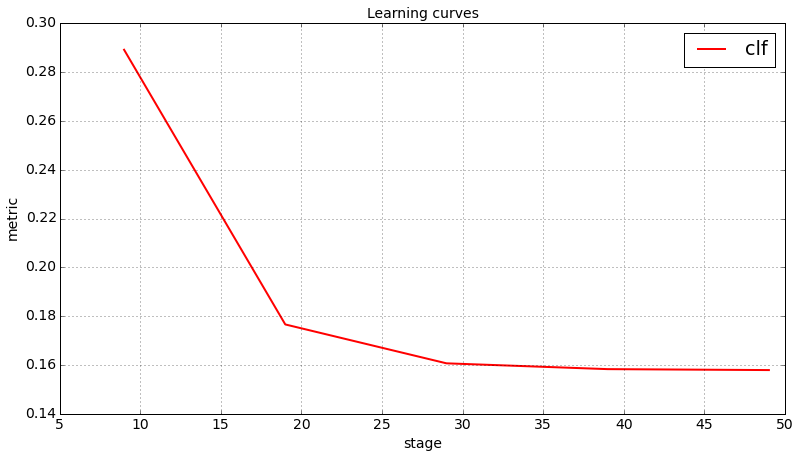

In [260]:
lc.plot(new_plot=True)

KFold prediction using folds column


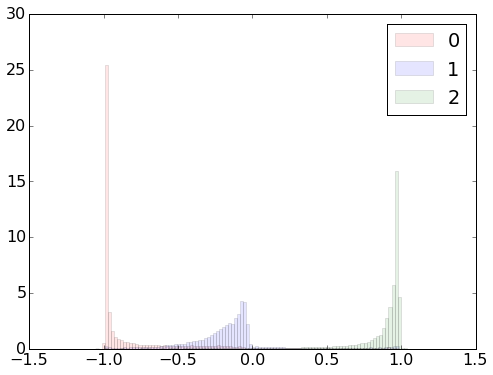

In [261]:
figsize(8, 6)
reg_values = xgb_folding_regression.predict(full_data)
for label in numpy.unique(labels):
    hist(reg_values[labels == label], 
         bins=100, alpha=0.1, normed=True,  label=str(label))
legend()

In [262]:
full_data['xgb_reg'] = xgb_folding_regression.predict(full_data)

KFold prediction using folds column


### Decision Train regression

In [268]:
tt_base = DecisionTrainRegressor(learning_rate=0.02, n_estimators=10000, depth=6, pretransform_needed=True, 
                                 max_features=0.7, loss=MSELossFunction(regularization=100))
tt_folding_regression = FoldingRegressor(tt_base, n_folds=2, random_state=11,
                                         parallel_profile='threads-2', 
                                         features=sv_features)
%time tt_folding_regression.fit_lds(data_ranker_lds)
pass

CPU times: user 1min 7s, sys: 13.2 s, total: 1min 21s
Wall time: 39.6 s


In [269]:
report_dt_reg = tt_folding_regression.test_on_lds(data_ranker_lds)

KFold prediction using folds column


In [270]:
lc_dt = report_dt_reg.learning_curve(mean_squared_error, steps=1)

KFold prediction using folds column


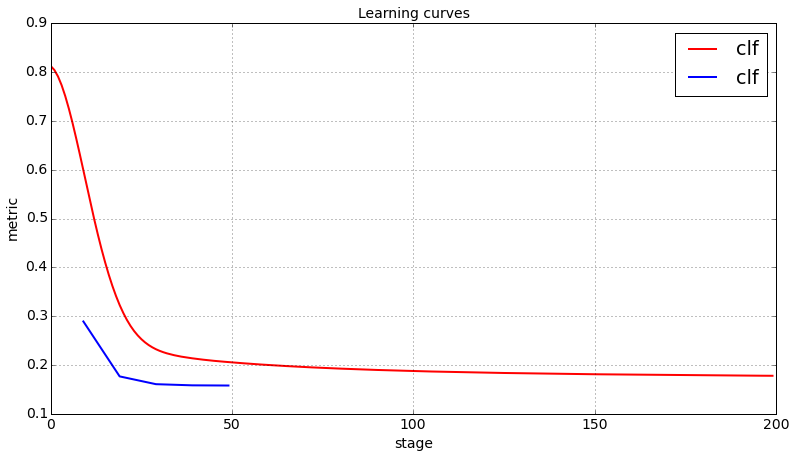

In [271]:
lc_dt.plot(new_plot=True)
lc.plot()
# ylim(0.16, 0.18)

KFold prediction using folds column


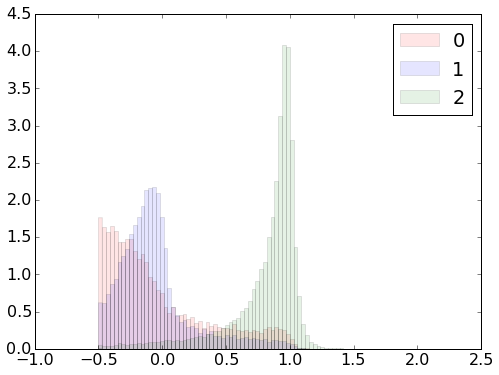

In [277]:
figsize(8, 6)
reg_values = tt_folding_regression.predict(full_data)
for label in numpy.unique(labels):
    hist(reg_values[labels == label], 
         bins=100, alpha=0.1, normed=True, range=(-0.5, 2.5), label=str(label))
xlim(-1, 2.5)
# ylim(0, 0.05)
legend()

### Ranker

In [278]:
from hep_ml.gradientboosting import UGradientBoostingRegressor
from hep_ml.losses import RankBoostLossFunction
from rep.estimators import SklearnClassifier

### decision train ranker

In [280]:
full_data['fake_request'] = 0

In [286]:
tt_base = DecisionTrainRegressor(learning_rate=0.02, n_estimators=10000, depth=6, pretransform_needed=True, 
                                 max_features=6, 
                                 train_features=sv_features + rbf_features,
                                 loss=RankBoostLossFunction(request_column='fake_request'))
tt_folding_ranking = FoldingRegressor(SklearnClassifier(tt_base), n_folds=2, random_state=11,
                                      parallel_profile='threads-2', features=sv_features + rbf_features + ['fake_request'])
%time tt_folding_ranking.fit_lds(data_multi_lds)
pass

CPU times: user 10min 21s, sys: 50.2 s, total: 11min 12s
Wall time: 6min 2s


In [290]:
tt_folding_ranking.estimators[0].feature_importances_

array([ 0.047 ,  0.047 ,  0.0622,  0.0628,  0.0637,  0.0422,  0.0198,
        0.0511,  0.0577,  0.0395,  0.0501,  0.0461,  0.0531,  0.029 ,
        0.102 ,  0.1261,  0.1006])

KFold prediction using folds column


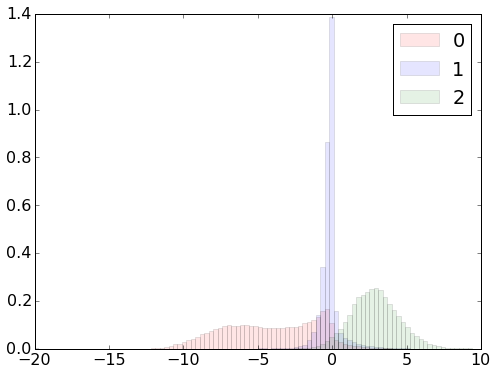

In [291]:
tt_ranks = tt_folding_ranking.predict(full_data)
for label in numpy.unique(labels):
    hist(tt_ranks[labels == label], bins=100, alpha=0.1, 
         normed=True, range=(-20, 10), label=str(label))
legend()

In [292]:
full_data['dt_rank'] = tt_folding_ranking.predict(full_data)

KFold prediction using folds column


### ugb ranker

In [55]:
ranker_base = UGradientBoostingRegressor(loss=RankBoostLossFunction(request_column='fake_request'), subsample=0.6, 
                                         n_estimators=400, max_depth=6, 
                                         train_features=sv_features + ['bdt1', 'bdt2'])
ranker = FoldingRegressor(ranker_base, n_folds=2, random_state=11,
                          parallel_profile='threads-2')
%time ranker.fit_lds(data_multi_lds)
pass

CPU times: user 4min 32s, sys: 1.64 s, total: 4min 33s
Wall time: 2min 19s


In [67]:
ranker.estimators[0].feature_importances_

array([ 0.100652  ,  0.10031386,  0.09663487,  0.08486942,  0.08862554,
        0.01144869,  0.01208862,  0.04759602,  0.04616032,  0.04938687,
        0.05137088,  0.11066463,  0.20018827])

In [56]:
ranks = ranker.predict(full_data)
tt_ranks = tt_folding_ranking.predict(full_data)

KFold prediction using folds column
KFold prediction using folds column


### pdfs form for dt ranker

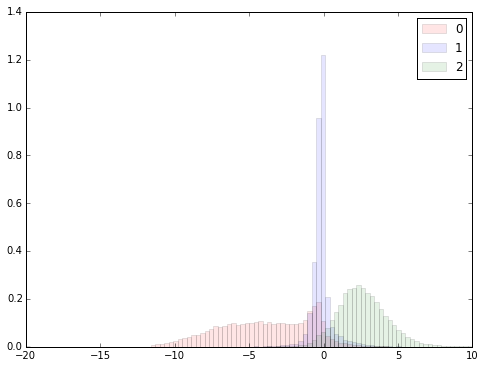

In [57]:
for label in numpy.unique(full_data.label.values):
    hist(tt_ranks[full_data.label.values == label], bins=100, alpha=0.1, 
         normed=True, range=(-20, 10), label=str(label))
legend()

### pdfs from for ugb ranker

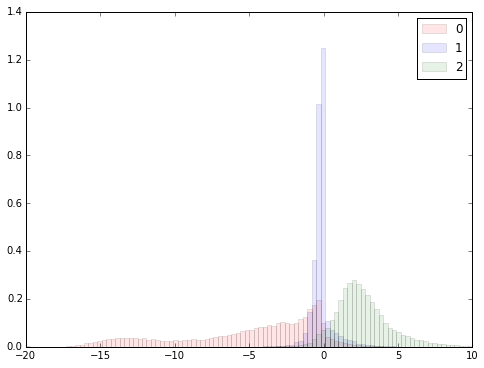

In [58]:
for label in numpy.unique(full_data.label.values):
    hist(ranks[full_data.label.values == label], bins=100, alpha=0.1, normed=True, range=(-20, 10), label=str(label))
legend()

In [59]:
labels = full_data.label.values
ranker_result = generate_result(roc_auc_score(labels[labels != 2] > 0, ranks[labels != 2]),
                                roc_auc_score(labels[labels != 1] > 0, ranks[labels != 1]),
                                roc_auc_score(labels[labels != 0] > 1, ranks[labels != 0]), 
                                label='ranker')

In [60]:
tt_ranker_result = generate_result(roc_auc_score(labels[labels != 2] > 0, tt_ranks[labels != 2]),
                                   roc_auc_score(labels[labels != 1] > 0, tt_ranks[labels != 1]),
                                   roc_auc_score(labels[labels != 0] > 1, tt_ranks[labels != 0]), 
                                   label='dt ranker')

# Results

In [61]:
result = pandas.concat([baseline_result, multiclass_result,
                       regression_result, ranker_result, tt_ranker_result])
result.index = result['name']
result = result.drop('name', axis=1)
result

,b vs c,b vs light,c vs light
name,,,
baseline,0.948797,0.981854,0.967735
multiclass,0.948900,0.983470,0.973202
regression,0.896365,0.982162,0.943175
ranker,0.898323,0.982022,0.940905
dt ranker,0.898226,0.981927,0.942289
